In [1]:
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from efficient_net_pytorch import EfficientNet
from sklearn.metrics import classification_report, accuracy_score

from IPython.display import clear_output
clear_output()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
eff_net = dict()
def get_eff_net(name):
    if name not in eff_net.keys():
        full_name = "efficientnet-" + name
        eff_net[name] = EfficientNet.from_name(full_name, override_params={'num_classes': 10})
    return eff_net[name]
clear_output()

In [3]:
eff_net_pretrained = dict()
def get_eff_net_pretrained(name):
    if name not in eff_net_pretrained.keys():
        full_name = "efficientnet-" + name
        eff_net_pretrained[name] = EfficientNet.from_pretrained(full_name, num_classes=10)
    return eff_net_pretrained[name]
clear_output()

## Prepare data

In [4]:
def get_dataset(model_name="b0"):
    resolution = EfficientNet.get_image_size("efficientnet-" + model_name)
    tfms = transforms.Compose([#transforms.Resize((300, 200)), 
                               transforms.Resize(resolution),
                               transforms.CenterCrop(resolution), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
    cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=tfms)
    test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tfms)
    
    clear_output()
    return cifar, test_data

## Utils

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def plot_graph(loss_list, accuracy_list):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(range(len(loss_list)), loss_list, color="green")
    plt.ylabel("LOSS - Train data")
    plt.xlabel("Recorded after every 25 mini batches")
    plt.subplot(122)
    plt.plot(range(len(accuracy_list)), accuracy_list, color="orange")
    plt.ylabel("ACCURACY - Test data")
    plt.xlabel("Recorded after every 25 mini batches")
    plt.ylim(0,1)
    plt.show()

## Train & Eval

In [7]:
def train(model, optim, scheduler, train_data, val_data, epochs, batch_size):
    loss_list, accuracy_list = list(), list()
    criterion = nn.CrossEntropyLoss().to(device)
    model.to(device)
    model.train()
    dataloader = DataLoader(train_data, batch_size, shuffle=True)
    loss_meter = AverageMeter()
    for epoch in range(epochs):
        print("EPOCH: ", epoch)
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            optim.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss_meter.update(loss.item(), inputs.size(0))
            if batch_idx % 25 == 0:
                accuracy = evaluate(model, val_data, batch_size)
                print(f"   BATCH: {batch_idx:>3}, TRAIN_LOSS: {loss_meter.avg:.5f}, VAL_ACCU: {accuracy:.3f}")
                loss_list.append(loss_meter.avg)
                accuracy_list.append(accuracy)
                loss_meter.reset()
            loss.backward()
            optim.step()
        scheduler.step()
    return loss_list, accuracy_list

In [8]:
def evaluate(model, data, batch_size=32, print_accu=False):  
    model.eval()
    accuracy_meter = AverageMeter()
    dataloader = DataLoader(data, batch_size, shuffle=False)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader): 
            outputs = model(inputs.to(device))
            outputs = torch.topk(outputs, k=1).indices.squeeze(0).flatten().cpu().tolist()
            targets = targets.flatten().cpu().tolist()
            accuracy_meter.update(accuracy_score(outputs, targets), len(targets))
    model.train()
    if print_accu:
        percentage = accuracy_meter.avg*100
        print(f"ACCURACY - Test data: {percentage:.2f}%")
    else:
        return accuracy_meter.avg

## B0 - w/ pretrained weights

In [9]:
total_loss, total_accu = list(), list()

In [10]:
model_name = "b0"
epochs = 15
batch_size = 200
model = get_eff_net_pretrained(model_name)
optim = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, [3,5,6,7,8,9,10], gamma=0.5)
train_data, test_data = get_dataset(model_name)

# batch_size 64 => 8319MiB
# batch_size 128 => 15583MiB 
# batch_size 200 => 23855MiB 

EPOCH:  0
   BATCH:   0, TRAIN_LOSS: 2.33756, VAL_ACCU: 0.096
   BATCH:  25, TRAIN_LOSS: 0.92184, VAL_ACCU: 0.826
   BATCH:  50, TRAIN_LOSS: 0.32371, VAL_ACCU: 0.835
   BATCH:  75, TRAIN_LOSS: 0.26423, VAL_ACCU: 0.826
   BATCH: 100, TRAIN_LOSS: 0.23535, VAL_ACCU: 0.848
   BATCH: 125, TRAIN_LOSS: 0.21604, VAL_ACCU: 0.864
   BATCH: 150, TRAIN_LOSS: 0.21438, VAL_ACCU: 0.847
   BATCH: 175, TRAIN_LOSS: 0.18713, VAL_ACCU: 0.887
   BATCH: 200, TRAIN_LOSS: 0.17599, VAL_ACCU: 0.911
   BATCH: 225, TRAIN_LOSS: 0.16481, VAL_ACCU: 0.884
EPOCH:  1
   BATCH:   0, TRAIN_LOSS: 0.18779, VAL_ACCU: 0.927
   BATCH:  25, TRAIN_LOSS: 0.10377, VAL_ACCU: 0.929
   BATCH:  50, TRAIN_LOSS: 0.09435, VAL_ACCU: 0.939
   BATCH:  75, TRAIN_LOSS: 0.09686, VAL_ACCU: 0.934
   BATCH: 100, TRAIN_LOSS: 0.09293, VAL_ACCU: 0.946
   BATCH: 125, TRAIN_LOSS: 0.09859, VAL_ACCU: 0.924
   BATCH: 150, TRAIN_LOSS: 0.10412, VAL_ACCU: 0.935
   BATCH: 175, TRAIN_LOSS: 0.11373, VAL_ACCU: 0.926
   BATCH: 200, TRAIN_LOSS: 0.11395, VAL_ACCU

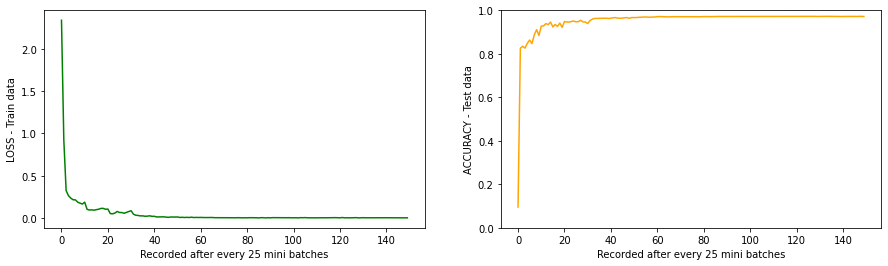

In [11]:
loss_list, accuracy_list = train(model, optim, lr_scheduler, train_data, test_data, epochs, batch_size)
total_loss = total_loss + loss_list
total_accu = total_accu + accuracy_list
plot_graph(total_loss, total_accu)

In [12]:
evaluate(model, test_data, print_accu=True)

ACCURACY - Test data: 97.23%
